In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics
import math

In [ ]:

# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [ ]:
tempdf = pd.DataFrame()
tempdf['Tmean'] = dataframe[['pH','Salinity','Ammonia']].mean()
tempdf['Tstd'] = dataframe[['pH','Salinity','Ammonia']].std()
for date in dataframe['Date of Image'].unique():
  df = dataframe.loc[dataframe['Date of Image'] == date]
  tempdf[f'{date}_mean'] = df[['pH','Salinity','Ammonia']].mean()
  tempdf[f'{date}_std'] = df[['pH','Salinity','Ammonia']].std()

In [ ]:
tempdf

,Tmean,Tstd,2022-07-14_mean,2022-07-14_std,2022-09-12_mean,2022-09-12_std,2023-04-25_mean,2023-04-25_std,2023-05-30_mean,2023-05-30_std,2023-07-09_mean,2023-07-09_std
pH,8.205357,0.361522,8.600,0.106904,8.43750,0.170783,7.6250,0.150000,7.900000,0.264575,8.166667,0.276887
Salinity,33.678571,6.390638,37.875,1.807722,35.56250,3.898183,26.0000,3.366502,24.923077,1.754116,39.066667,2.051712
Ammonia,0.043750,0.032784,0.000,0.000000,0.02625,0.015438,0.0275,0.009574,0.074615,0.025038,0.063333,0.024398


In [ ]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,821,759,964,800,1132,1074,1130,924,1135,1643
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,645,645,833,639,879,885,971,696,911,1296
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,573,541,694,528,768,633,710,574,801,1673
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,699,558,662,637,699,780,869,538,858,1599
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,957,732,968,1040,1261,1274,1236,808,1200,1759


In [ ]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 22


In [ ]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [ ]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.042532
Salinity    0.142014
Ammonia     0.065567
dtype: float64

## WQI calculation

In [ ]:


def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.30,0.30,0.4]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 0
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf

def bandmath(bandMatrix):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/(bandMatrix[a] + bandMatrix[b])
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex

    # df[[f'diff_{a}_{b}',f'norm_{a}_{b}',f'ratio_{a}_{b}']] = diffIndex.values,normlizedIndex.values,ratioIndex.values
    # print(len(diffIndex.values),len(normlizedIndex.values),len(ratioIndex.values))


  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  pcadf = pd.DataFrame(pca_data,index = data.index,columns = ['pc1','pc2','pc3'])
  return  pcadf

def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 2.,  4.,  4.,  2.,  3.,  7., 10.,  6., 13.,  5.]),
 array([17.86666667, 22.70666667, 27.54666667, 32.38666667, 37.22666667,
        42.06666667, 46.90666667, 51.74666667, 56.58666667, 61.42666667,
        66.26666667]),
 <BarContainer object of 10 artists>)

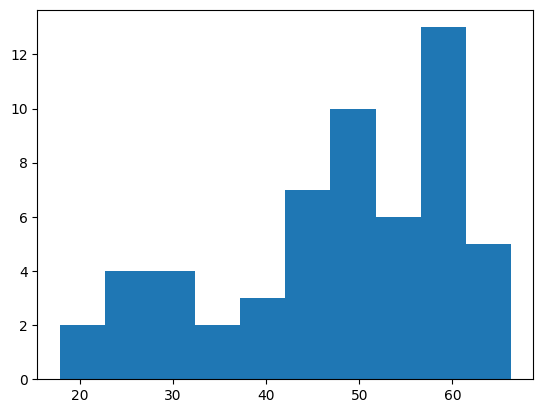

In [ ]:
wqi,expdf= calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [ ]:
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 47.113095238095234
Standard Deviation WQI 12.664516051194644


## Model for the WQI to indiviual parameter

In [ ]:
def CM(actual, predicted):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  plt.show()

def Presults(y_test, prediction):
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_

def LRegression(WQI,GT,WQI_val,GT_val):
  CM(GT,WQI)
  X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
  model = LinearRegression().fit(X_train, y_train)
  # model = SVR(kernel='rbf', C=2.0, epsilon=0.2).fit(X_train, y_train)
  if GT.name == 'Ammonia':
    # print('hi')
    model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
  prediction = model.predict(X_test)
  prediction_val = model.predict(WQI_val)
  for x,y in zip(y_test.values,prediction):
    print(x,'-',y)
  Presults(y_test, prediction)
  print(f"validation results on {GT_val.name}")
  Presults(GT_val,prediction_val)
  # for x,y in zip(GT_val,prediction_val):
  #   print(x,'-',y)
  # print(f"---------------------------------------")


#to predict the parameters from WQI



def WQIandParameters(WQI,GT,predictedWQI,gtforRE):
  print('-----For WQI with pH Regression relation-----')
  LRegression(WQI,GT['pH'],predictedWQI,gtforRE['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(WQI,GT['Salinity'],predictedWQI,gtforRE['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(WQI,GT['Ammonia'],predictedWQI,gtforRE['Ammonia'])
  return None



In [ ]:
### adding wqi as a dataframe
dataframe["WQI"] = wqi

In [ ]:
def bandmath(bandMatrix):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/(bandMatrix[a] + bandMatrix[b])
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex

    # df[[f'diff_{a}_{b}',f'norm_{a}_{b}',f'ratio_{a}_{b}']] = diffIndex.values,normlizedIndex.values,ratioIndex.values
    # print(len(diffIndex.values),len(normlizedIndex.values),len(ratioIndex.values))


  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  pcadf = pd.DataFrame(pca_data,index = data.index,columns = ['pc1','pc2','pc3'])
  return  pcadf

In [ ]:
df = dataframe[bands]
df_norm = (df-df.min())/(df.max()-df.min())
bandcombodf = bandmath(df_norm)

In [ ]:
def masterdfGen(df):

  df[parameters] = dataframe[parameters]
  df["Date of Image"] = dataframe["Date of Image"]
  df.replace([np.inf, -np.inf], 0, inplace=True)
  df.replace([np.nan], 0, inplace=True)
  df["WQI"] = wqi
  return df


usefulCombos = bandcombodf.corrwith(dataframe["WQI"]).sort_values(ascending=False)[:3].index

def derivative(df):
  deridf = pd.DataFrame(index = df.index)
  for combo in df.columns:
    deridf[combo] = np.gradient(df[combo])
  deridf.replace([np.nan], 0, inplace=True)
  return deridf

basedf = bandcombodf[usefulCombos]

dfd1 = derivative(bandcombodf[usefulCombos])
dfd2 = derivative(dfd1)
dfd3 = derivative(dfd2)



# bands = usefulCombos

In [ ]:
Pca = False
finaldf = basedf

if Pca:
  temp = pca(finaldf)
  Newmasterdf = masterdfGen(temp)
  usefulCombos = ['pc1', 'pc2', 'pc3']
else:
  Newmasterdf = masterdfGen(finaldf)
  usefulCombos = usefulCombos
Newmasterdf.head()

<ipython-input-1011-342347a91e09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[parameters] = dataframe[parameters]
<ipython-input-1011-342347a91e09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[parameters] = dataframe[parameters]
<ipython-input-1011-342347a91e09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,diff_B1_B2,norm_B9_B11,diff_B9_B11,pH,Salinity,Ammonia,Date of Image,WQI
0,-0.156540,-0.106468,-0.068403,8.4,35,0.0,2022-07-14,50.333333
1,-0.120813,0.002407,0.000938,8.7,38,0.0,2022-07-14,61.333333
2,-0.026794,0.358224,0.155595,8.7,39,0.0,2022-07-14,62.000000
3,-0.014789,0.158598,0.075397,8.7,40,0.0,2022-07-14,62.666667
4,-0.083422,-0.196429,-0.155332,8.6,36,0.0,2022-07-14,57.000000


## Model for Band to WQI index

In [1]:

def scaling(Banddata):
    scaler = StandardScaler()
    scaler.fit(Banddata)
    dataframe = scaler.transform(Banddata)
    return dataframe

def pca(dataframe):
  pca = PCA(n_components=3)
  pca.fit(dataframe)
  pca_df =  pca.transform(dataframe)
  return pca_df

# def weakmodel(xTrain, yTrain,xTest):
#       models = [
#         RandomForestRegressor(max_depth=3, random_state=0),
#         xgb.XGBRegressor(),
#         SVR(kernel='rbf', C=1.0, epsilon=1e-3)]

#       preds = []
#       for i, m in enumerate(models):
#           m.fit(xTrain, yTrain)
#           preds.append(m.predict(xTest))

#       weights = [0.33, 0.33,0.33]
#       preds = np.array(preds)
#       print
#       preds= np.sum(preds, axis = 0)/3
#       return preds

### model to predict WQI using bands as input
def predictWQI(dataframe,pred):
    validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    # traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    # traindataframe.to_csv('WQIModelTrain.csv')
    # validationdataframe.to_csv('WQIModelTest.csv')

    # validationdataframe = dataframe[dataframe["Date of Image"]=="2022-09-12"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2022-09-12"]
    k =  10
    k_fold = KFold(n_splits = k,shuffle=True )


    gtforRE = (validationdataframe[parameters])

    xTrain = ((traindataframe[usefulCombos]))
    yTrain = traindataframe[pred]
    xTest = ((validationdataframe[usefulCombos]))
    yTest = validationdataframe[pred]

    model = SVR(kernel='rbf', C=1.0, epsilon=1e-4)
    # model = MLPRegressor(random_state=1, max_iter=100000)

    model.fit(xTrain, yTrain)

    # score = cross_val_score(model, dataframe[bands], dataframe[pred], cv = k_fold)
    # print(sum(score) / len(score))
    # print(score)

    # prediction =  weakmodel(xTrain,yTrain,xTest)
    # prediction = preds
    # print(prediction,yTest)

    prediction = model.predict(xTest)




    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction,gtforRE

In [2]:
(Newmasterdf).corrwith(Newmasterdf['WQI'])

NameError: ignored

MAE 9.709437970423172
MSE 125.48183980115536
RMSE 11.201867692539283
MAPE 0.1837198772873035
R2 Score -0.5396498115424309


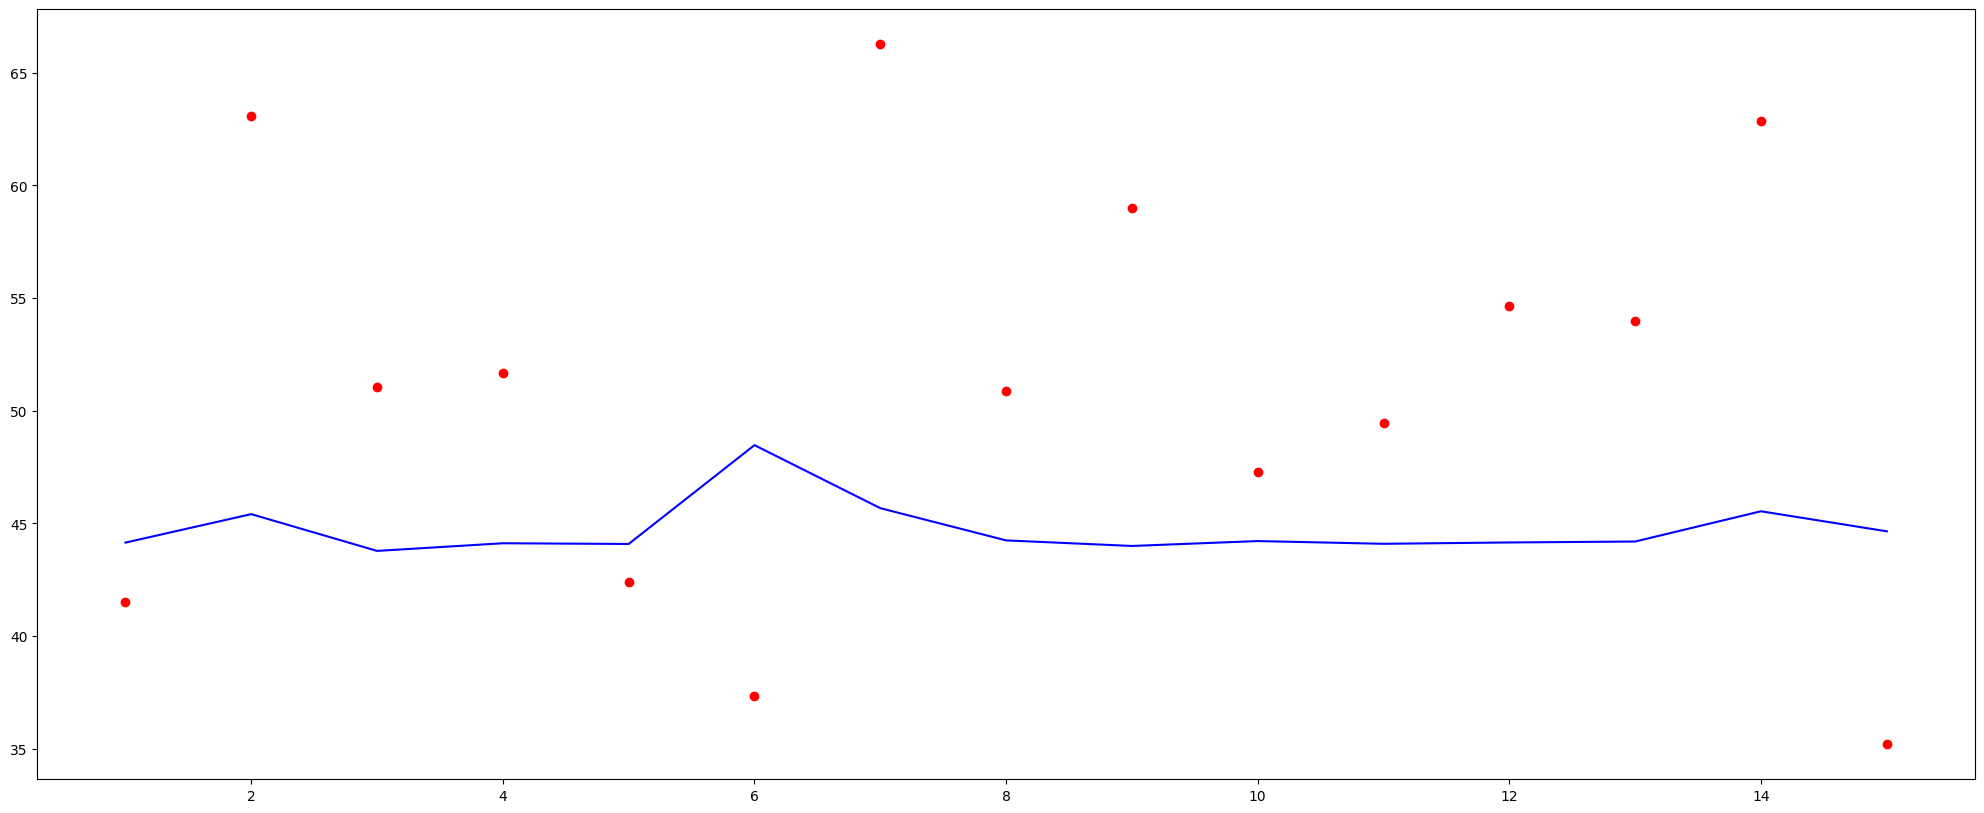

In [ ]:
predictedWQI,gtforRE = predictWQI(Newmasterdf,"WQI")

-----For WQI with pH Regression relation-----


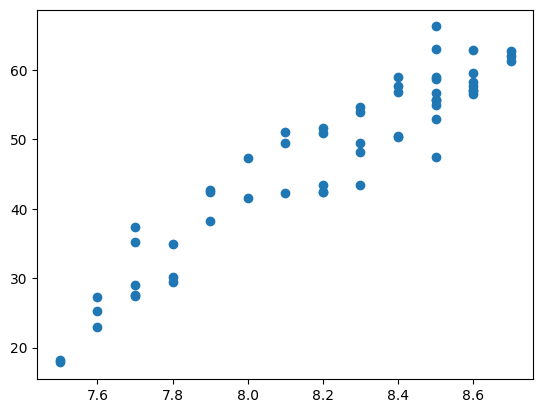

8.4 - 8.280007947769327
8.6 - 8.484558738778532
7.6 - 7.581126078487884
8.4 - 8.447057760426844
8.6 - 8.440239400726536
8.3 - 8.390806292899313
7.9 - 7.971477171330447
7.7 - 7.695333603468023
7.7 - 7.947612912379373
8.5 - 8.346486954847318
7.7 - 7.698742783318177
8.7 - 8.595357083908516
7.6 - 7.639082135940492
7.7 - 7.736243761669864
8.6 - 8.515241357429911
8.4 - 8.283417127619481
8.6 - 8.467512839527764
8.6 - 8.450466940276996
8.1 - 8.298758436945171
MAE 0.09960776923331771
MSE 0.014108425017333165
RMSE 0.11877889129526831
MAPE 0.012015207180133948
R2 Score 0.913234387883181
validation results on pH
MAE 0.25084708707294845
MSE 0.08866892310804929
RMSE 0.29777327467059445
MAPE 0.03110334025126755
R2 Score -0.23916196890131047
-----For WQI with Salinity  Regression relation-----


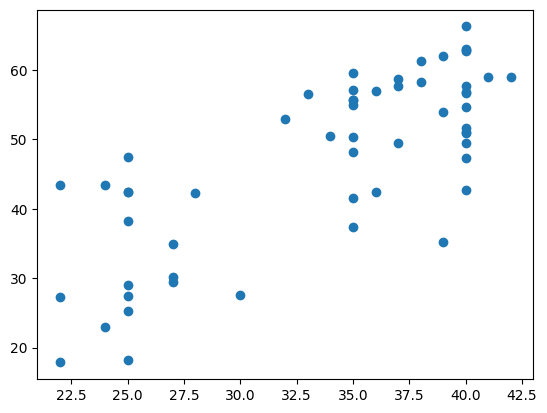

35 - 35.05591258371943
38 - 38.257145520945954
24 - 24.11836671486212
40 - 37.67025281578776
33 - 37.56354505121353
40 - 36.78991375805047
25 - 30.227386236736084
25 - 25.905721771480266
35 - 29.853909060726316
32 - 36.09631328831804
30 - 25.95907565376738
40 - 39.99114669527698
25 - 25.025382713742967
25 - 26.54596835892557
35 - 38.73733046152993
34 - 35.10926646600653
37 - 37.99037610951041
36 - 37.72360669807486
40 - 35.349358936298515
MAE 2.302245529218857
MSE 8.818292723364475
RMSE 2.9695610320996058
MAPE 0.070449311411218
R2 Score 0.7234227912133296
validation results on Salinity
MAE 4.489998746763007
MSE 24.635007113990664
RMSE 4.963366510141142
MAPE 0.11238351792154878
R2 Score -5.2702223989229635
-----For WQI with Ammonia SVR relation-----


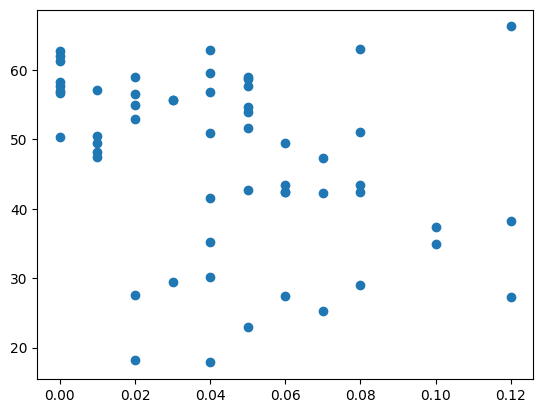

0.0 - 0.031179483394766692
0.0 - 0.028396749608970803
0.05 - 0.05954246826077787
0.04 - 0.028083694053415247
0.02 - 0.028083694053415247
0.05 - 0.029284481932203135
0.12 - 0.05883913116830378
0.06 - 0.06092648786862101
0.1 - 0.05883913116830378
0.02 - 0.03104823339476669
0.02 - 0.06092648786862101
0.0 - 0.04238858693829618
0.07 - 0.05954246826077787
0.08 - 0.05774003114551954
0.04 - 0.02800158831864822
0.01 - 0.031179483394766692
0.0 - 0.028396749608970803
0.0 - 0.028083694053415247
0.08 - 0.031457261172544465
MAE 0.025177070064509064
MSE 0.0008781314372405597
RMSE 0.029633282593066867
MAPE 37556527901447.0
R2 Score 0.3272380117915066
validation results on Ammonia
MAE 0.032408535621390865
MSE 0.0015719550130674686
RMSE 0.03964788787649941
MAPE 0.45329513447766345
R2 Score -1.8295190235214442


In [ ]:
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)
WQIandParameters(np.array(Newmasterdf['WQI']).reshape(-1, 1),Newmasterdf[parameters],predictedWQI.reshape(-1, 1),gtforRE)

## Harmonic WQI model

In [ ]:
allWQI = harmonizedWQIcalculation(dataframe[parameters])
dataframe['HWQI'] = allWQI

(array([ 4.,  3.,  1., 20.,  5., 15.,  3.,  3.,  0.,  2.]),
 array([20.74961791, 21.84151438, 22.93341084, 24.02530731, 25.11720377,
        26.20910023, 27.3009967 , 28.39289316, 29.48478963, 30.57668609,
        31.66858255]),
 <BarContainer object of 10 artists>)

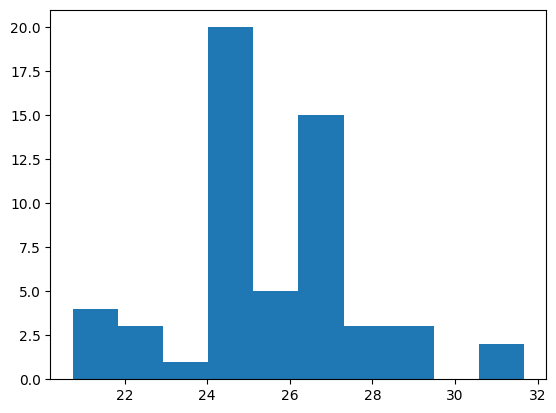

In [ ]:
plt.hist(dataframe['HWQI'])

In [ ]:
(dataframe).corrwith(dataframe['HWQI'])

<ipython-input-1005-0036a586283d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['HWQI'])


pH             0.106968
Salinity       0.559821
Carbonate     -0.014115
BiCarbonate   -0.051408
Alkalinity    -0.010036
Hardness       0.433366
Calcium       -0.268119
Magnesium      0.457176
Ammonia        0.585113
Coincidence         NaN
AOT           -0.274742
B1            -0.412357
B11           -0.263832
B12           -0.322043
B2            -0.464303
B3            -0.440455
B4            -0.409759
B5            -0.305959
B6            -0.261379
B7            -0.250554
B8            -0.294621
B8A           -0.251498
B9            -0.298033
WQI            0.401104
HWQI           1.000000
dtype: float64

In [ ]:
predictedWQI,gtforRE = predictWQI(dataframe,"HWQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)

WQIandParameters(np.array(dataframe['HWQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

KeyError: ignored

In [ ]:
## Not good code

In [ ]:


# #to train model to predict the WQI using band  indcies using ML
# def WQIandBands(df1,WQI):
#   print('-----For WQI prediction with Bands with SVR algo -----')
#   X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
#   X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
#   # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
#   model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
#   model.fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   return prediction


# def CM(actual, predicted):
#   fig = plt.figure()
#   plt.scatter(actual, predicted)
#   plt.show()

# def LRegression(WQI,GT):
#   X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
#   model = LinearRegression().fit(X_train, y_train)
#   # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
#   # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   for x,y in zip(y_test.values,prediction):
#     print(x,'-',y)

#   CM(WQI,GT)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   # return model.coef_,model.intercept_
# #to predict the parameters from WQI



# def WQIandParameters(WQI,GT):
#   print('-----For WQI with pH Regression relation-----')
#   LRegression(WQI,GT['pH'])
#   print('-----For WQI with Salinity  Regression relation-----')
#   LRegression(WQI,GT['Salinity'])
#   print('-----For WQI with Ammonia SVR relation-----')
#   LRegression(WQI,GT['Ammonia'])
#   return None



## WQI with only bands

In [ ]:
# WQI = WQIcalculation(df1 ,GT1)
# # len(WQI)
# WQIandBands(df1,WQI)
# WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

## WQI with  top  10 combination indices

In [ ]:
#   corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
# type(corrwithWQI)
# corrdict  = corrwithWQI.to_dict()
# sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
# for r in sortedkeys[:11]:
#     print(r, corrdict[r])

In [ ]:
# newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
# scaler = StandardScaler()
# scaler.fit(newtraindf)
# newscaledtraindf = scaler.transform(newtraindf)
# WQIandBands(newscaledtraindf,WQI)

In [ ]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands